In [55]:
import numpy as np
import random
import torch
import torch.nn.functional as F
import torchaudio
from torch.utils.data import ConcatDataset, random_split, DataLoader
import matplotlib.pyplot as plt
import multiprocessing as mp

from datasets import GunshotDataset
from models import *
from utils import train_one_epoch, evaluate

In [58]:
cadre_1 = GunshotDataset(root_dir="data/positive/cadre", label=1., sample_rate=44100)
ncbi_1 = GunshotDataset(root_dir="data/positive/ncbi", label=1., sample_rate=44100)
# paper_1 = GunshotDataset(root_dir="data/positive/paper", label=1., sample_rate=44100)
# paper_0 = GunshotDataset(root_dir="data/negative/paper", label=0., sample_rate=44100)
esc50_0 = GunshotDataset(root_dir="data/negative/esc50", label=0., sample_rate=44100)
campus_0 = GunshotDataset(root_dir="data/negative/campus", label=0., sample_rate=44100)

In [59]:
print(len(cadre_1))
print(len(ncbi_1))
print(len(paper_1))
print(len(paper_0))
print(len(esc50_0))
print(len(campus_0))

5017
2148
959
6068
2000
62


data/positive/paper/data/Audio Sample #390 (Thu Jul 25 09:24:51 2019).wav


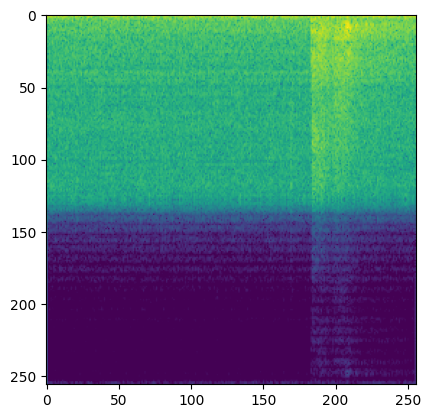

data/positive/cadre/Kimber45_Zoom/ZM_076B_S02.wav


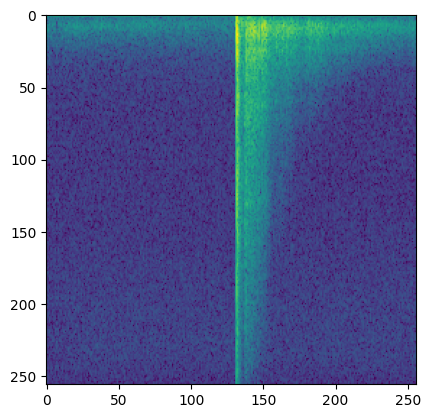

data/positive/ncbi/remington_870_12_gauge/cad6cdd9-faca-4577-95f4-4be31f757b0c_chan5_v1.wav


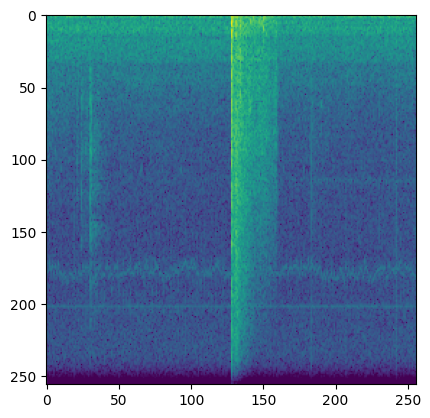

In [88]:
index = 0
# spec, label = paper_1[index]
# print(paper_1.filepaths[index])
# plt.imshow(spec[index])
# plt.show()
spec, label = cadre_1[index]
print(cadre_1.filepaths[index])
plt.imshow(spec[index])
plt.show()
# spec, label = ncbi_1[index]
# print(ncbi_1.filepaths[index])
# plt.imshow(spec[index])
# plt.show()
# spec, label = campus_0[index]
# print(campus_0.filepaths[index])
# plt.imshow(spec[index], origin='lower')
# plt.show()

data/negative/paper/data/Audio Sample #1881 (Mon Aug  5 15:33:44 2019).wav


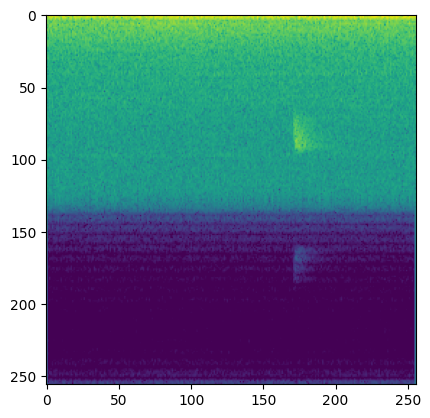

data/negative/esc50/data/1-104089-A-22.wav


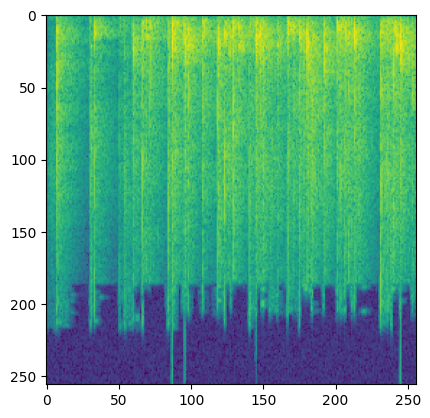

data/negative/campus/business_school/chunk2.wav


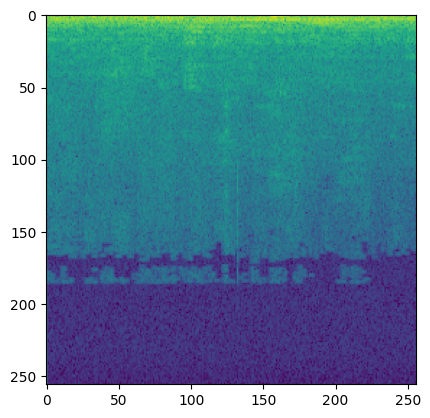

In [93]:
index = 0
spec, label = paper_0[index]
print(paper_0.filepaths[index])
plt.imshow(spec[index])
plt.show()
spec, label = esc50_0[index]
print(esc50_0.filepaths[index])
plt.imshow(spec[index])
plt.show()
spec, label = campus_0[index]
print(campus_0.filepaths[index])
plt.imshow(spec[index])
plt.show()

In [89]:
positives = ConcatDataset([cadre_1, ncbi_1, paper_1])
negatives = ConcatDataset([paper_0, esc50_0, campus_0])
print("Positives:", len(positives))
print("Negatives:", len(negatives))

Positives: 8124
Negatives: 8130


In [90]:
n = min(len(positives), len(negatives))
dataset_0, _ = random_split(negatives, [n, len(negatives) - n])
dataset_1, _ = random_split(positives, [n, len(positives) - n])
dataset_all = ConcatDataset([dataset_0, dataset_1])
print("Negatives:", len(dataset_0))
print("Positives:", len(dataset_1))
print("Total:", len(dataset_all))

Negatives: 8124
Positives: 8124
Total: 16248


In [91]:
# Train/Val/Test Split
train_size = int(0.8 * len(dataset_all))
test_size = (len(dataset_all) - train_size) // 2
train_dataset, valid_dataset, test_dataset = random_split(dataset_all, [train_size, test_size, test_size])
print("Train:", len(train_dataset))
print("Valid:", len(valid_dataset))
print("Test:", len(test_dataset))

Train: 12998
Valid: 1625
Test: 1625


In [92]:
# Hyperparameters
BATCH_SIZE = 256
NUM_EPOCHS = 25
LR = 1e-4
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
DEVICE

device(type='mps')

In [26]:
model = build_resnet18()
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
model.load_state_dict("checkpoints/resnet18.pth")

In [27]:
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

In [28]:
train_losses = []
val_losses = []
best_loss = float('inf')
savepath = "checkpoints/resnet34.pth"

for epoch in range(NUM_EPOCHS):
    train_losses.append(train_one_epoch(train_loader, model, criterion, optimizer, DEVICE, epoch, NUM_EPOCHS))
    val_loss, val_acc = evaluate(valid_loader, model, criterion, DEVICE)
    print(f"Validation: Accuracy = {val_acc:.4f}%, Avg loss = {val_loss:.8f}", end=" ")
    val_losses.append(val_loss)
    if val_loss <= best_loss:
        checkpoint = {'epoch': epoch,
                      'model_state_dict': model.state_dict(),
                      'optimizer_state_dict': optimizer.state_dict(),
                      'val_loss': val_loss}
        torch.save(checkpoint, savepath)
        print("-----> Checkpoint saved.")
        best_loss = val_loss
    else:
        print()

Epoch 1/25: 100%|██████████| 51/51 [00:48<00:00,  1.06batch/s, loss=0.189]


Validation: Accuracy = 55.8240%, Avg loss = 1.50599051 --> Checkpoint saved.


Epoch 2/25: 100%|██████████| 51/51 [00:47<00:00,  1.07batch/s, loss=0.0686]


Validation: Accuracy = 97.3978%, Avg loss = 0.06291420 --> Checkpoint saved.


Epoch 3/25: 100%|██████████| 51/51 [00:47<00:00,  1.07batch/s, loss=0.0314]


Validation: Accuracy = 98.0173%, Avg loss = 0.05502957 --> Checkpoint saved.


Epoch 4/25: 100%|██████████| 51/51 [00:49<00:00,  1.04batch/s, loss=0.0138]


Validation: Accuracy = 96.8401%, Avg loss = 0.14007705 


Epoch 5/25: 100%|██████████| 51/51 [00:47<00:00,  1.07batch/s, loss=0.012]  


Validation: Accuracy = 97.8934%, Avg loss = 0.05629089 


Epoch 6/25: 100%|██████████| 51/51 [00:47<00:00,  1.07batch/s, loss=0.00492]


Validation: Accuracy = 98.0173%, Avg loss = 0.05400341 --> Checkpoint saved.


Epoch 7/25: 100%|██████████| 51/51 [00:47<00:00,  1.07batch/s, loss=0.00168] 


Validation: Accuracy = 98.2032%, Avg loss = 0.05674666 


Epoch 8/25: 100%|██████████| 51/51 [00:47<00:00,  1.07batch/s, loss=0.0104] 


Validation: Accuracy = 97.1499%, Avg loss = 0.11866090 


Epoch 9/25: 100%|██████████| 51/51 [00:47<00:00,  1.07batch/s, loss=0.0175]


Validation: Accuracy = 91.5737%, Avg loss = 0.23510815 


Epoch 10/25: 100%|██████████| 51/51 [00:47<00:00,  1.06batch/s, loss=0.00889]


Validation: Accuracy = 98.0173%, Avg loss = 0.05998498 


Epoch 11/25: 100%|██████████| 51/51 [00:48<00:00,  1.06batch/s, loss=0.00267]


Validation: Accuracy = 98.3891%, Avg loss = 0.04859610 --> Checkpoint saved.


Epoch 12/25: 100%|██████████| 51/51 [00:48<00:00,  1.06batch/s, loss=0.001]   


Validation: Accuracy = 98.3271%, Avg loss = 0.05300527 


Epoch 13/25: 100%|██████████| 51/51 [00:47<00:00,  1.07batch/s, loss=0.00113] 


Validation: Accuracy = 98.4511%, Avg loss = 0.05720333 


Epoch 14/25: 100%|██████████| 51/51 [00:47<00:00,  1.07batch/s, loss=0.00039] 


Validation: Accuracy = 98.5750%, Avg loss = 0.05820003 


Epoch 15/25: 100%|██████████| 51/51 [00:48<00:00,  1.06batch/s, loss=0.000165]


Validation: Accuracy = 98.8228%, Avg loss = 0.05420375 


Epoch 16/25: 100%|██████████| 51/51 [00:47<00:00,  1.07batch/s, loss=0.000128]


Validation: Accuracy = 98.2032%, Avg loss = 0.06981211 


Epoch 17/25:  16%|█▌        | 8/51 [00:08<00:43,  1.01s/batch, loss=6.42e-5]


KeyboardInterrupt: 

In [29]:
test_loss, test_acc = evaluate(test_loader, model, criterion, DEVICE)
print(f"\nTest: Accuracy = {test_acc}%, Avg loss = {test_loss:.8f}")


Test: Accuracy = 98.07930607187113%, Avg loss = 0.08714940


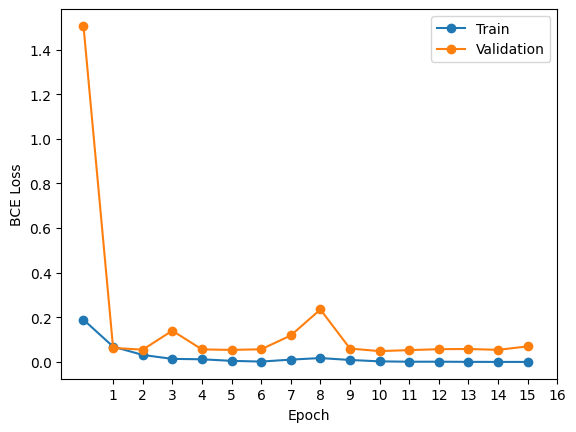

In [30]:
x = np.arange(1, epoch+1)
plt.plot(train_losses, label="Train", marker='o')
plt.plot(val_losses, label="Validation", marker='o')
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.xticks(x)
plt.legend()
plt.show()

In [32]:
checkpoint = torch.load(savepath)
best_model = models.resnet34(in_channels=1, num_classes=1)
best_model.load_state_dict(checkpoint['model_state_dict'])
best_model.eval()
best_model.to(DEVICE)
test_loss, test_acc = evaluate(test_loader, best_model, criterion, DEVICE)
print(f"\nTest: Accuracy = {test_acc}%, Avg loss = {test_loss:.8f}")


Test: Accuracy = 98.01734820322181%, Avg loss = 0.07449729


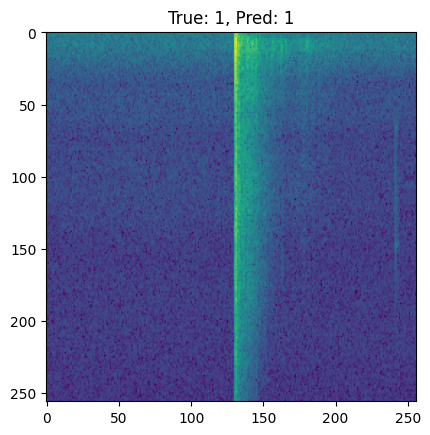

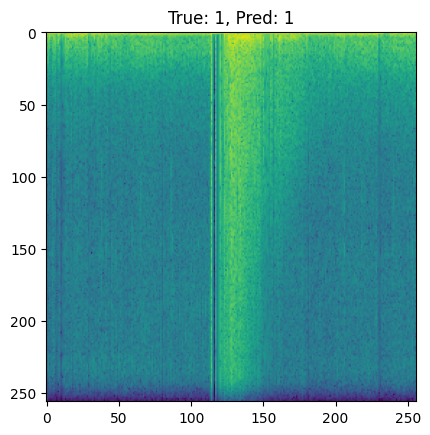

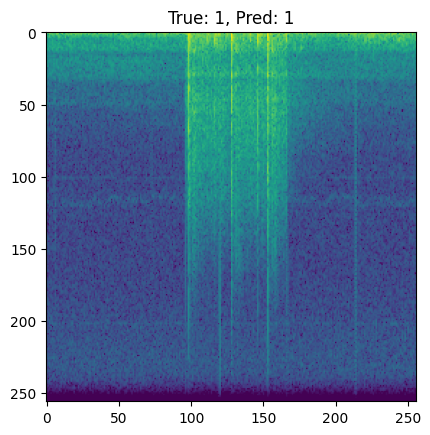

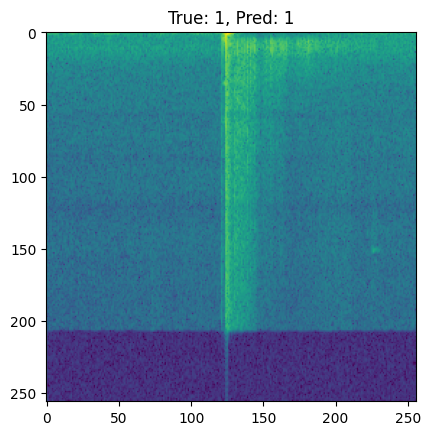

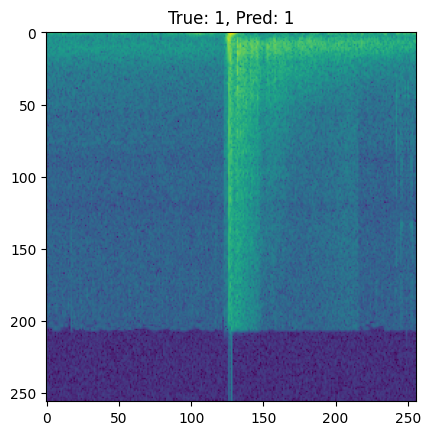

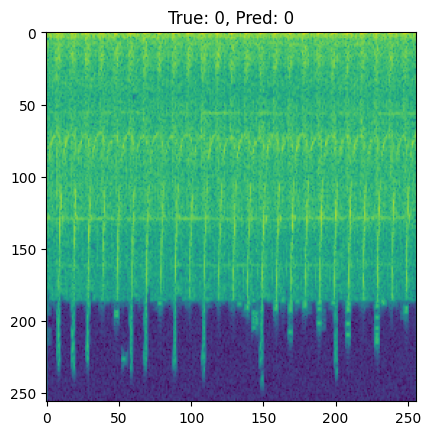

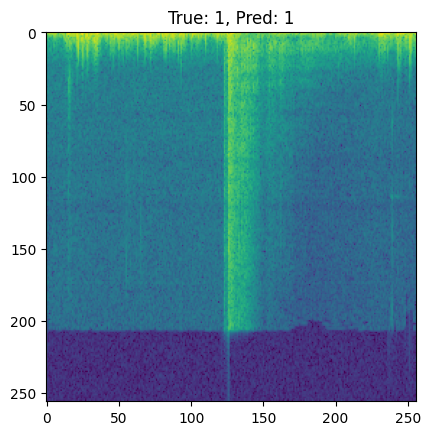

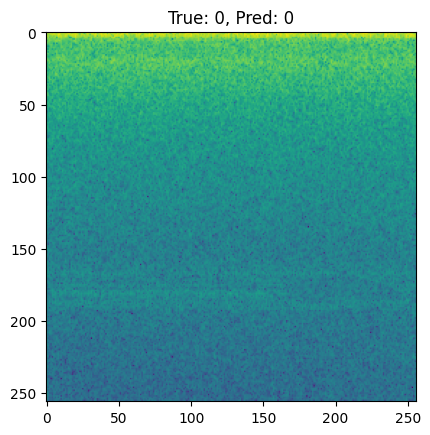

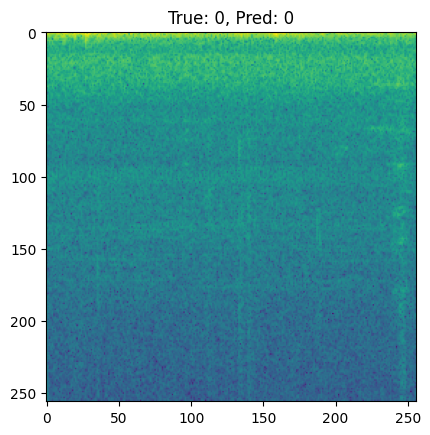

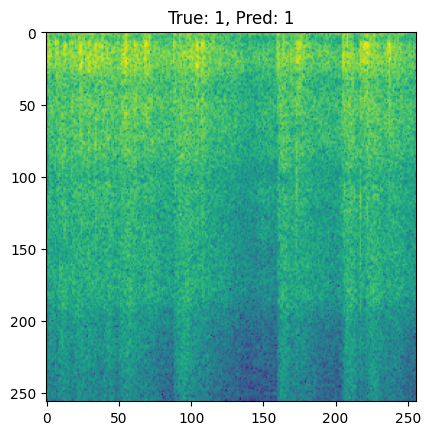

In [33]:
model.eval()
for _ in range(10):
    index = random.randint(0, len(test_dataset))
    spec, label = test_dataset[index]
    spec, label = spec.to(DEVICE), label.to(DEVICE)
    output = model(spec.unsqueeze(0))
    prediction = F.sigmoid(output).round().item()
    plt.imshow(spec.cpu()[0])
    plt.title(f"True: {int(label.item())}, Pred: {int(prediction)}")
    plt.show()